 # Power Load Prediction for West Zone - SARIMA Model (Monthly)

In [349]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
import pandas as pd

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook


%matplotlib inline
plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})

In [350]:
power_data_west = pd.read_csv("westdata_augmented.csv")

/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_85016/1727164072.py:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  power_data_west = pd.read_csv("westdata_augmented.csv")


In [351]:
power_data_west['end'] = pd.to_datetime(power_data_west['end'], infer_datetime_format=True)
indexedDataset = power_data_west.set_index(['end'])

In [352]:
power_data_west['end'].min()

Timestamp('2019-01-29 00:15:00')

In [353]:
power_data_west['end'].max()

Timestamp('2022-01-25 16:00:00')

In [354]:
power_data_west.head()

,Unnamed: 0,index_x,service,start,end,usage,cost,temp,event_flag,demand,sfm,index_y,dt,dt_iso,humidity,humidity_temp,pt_date
0,0,0,west,2019-01-29 00:00:00,2019-01-29 00:15:00,211.2,NaN,54.0,NaN,844.8,2019-01-29 00,680,1548748800,2019-01-29 08,21,63.86,2019-01-29 00
1,1,1,west,2019-01-29 00:15:00,2019-01-29 00:30:00,210.4,NaN,54.0,NaN,841.6,2019-01-29 00,680,1548748800,2019-01-29 08,21,63.86,2019-01-29 00
2,2,2,west,2019-01-29 00:30:00,2019-01-29 00:45:00,208.0,NaN,54.0,NaN,832.0,2019-01-29 00,680,1548748800,2019-01-29 08,21,63.86,2019-01-29 00
3,3,3,west,2019-01-29 00:45:00,2019-01-29 01:00:00,212.0,NaN,54.0,NaN,848.0,2019-01-29 00,680,1548748800,2019-01-29 08,21,63.86,2019-01-29 00
4,4,4,west,2019-01-29 01:00:00,2019-01-29 01:15:00,203.2,NaN,55.0,NaN,812.8,2019-01-29 01,681,1548752400,2019-01-29 09,21,63.41,2019-01-29 01


In [355]:
power_data_west['month'] = power_data_west['end'].dt.strftime('%b')

In [356]:
from calendar import month_abbr

lower_ma = [m.lower() for m in month_abbr]

# one-liner with Pandas
power_data_west['month_int'] = power_data_west['month'].str.lower().map(lambda m: lower_ma.index(m)).astype('Int8')

In [357]:
power_data_west_mod = power_data_west[['end','demand', 'temp', 'humidity', 'month_int']].copy() 

In [358]:
power_data_west_mod.head()

,end,demand,temp,humidity,month_int
0,2019-01-29 00:15:00,844.8,54.0,21,1
1,2019-01-29 00:30:00,841.6,54.0,21,1
2,2019-01-29 00:45:00,832.0,54.0,21,1
3,2019-01-29 01:00:00,848.0,54.0,21,1
4,2019-01-29 01:15:00,812.8,55.0,21,1


In [359]:
power_data_west_mod.describe()

,demand,temp,humidity,month_int
count,104596.000000,104588.00000,104608.000000,104608.00000
mean,1238.634456,67.39232,52.635401,6.54298
std,302.399419,16.59371,22.815913,3.43464
min,0.000000,29.00000,3.000000,1.00000
25%,1008.000000,54.00000,34.000000,4.00000
50%,1232.000000,66.00000,49.000000,7.00000
75%,1472.000000,79.00000,70.000000,10.00000
max,2124.800000,114.00000,100.000000,12.00000


In [360]:
power_data_west_mod.shape

(104608, 5)

In [361]:
power_data_west_monthly = power_data_west_mod.resample('M', on='end').agg({'demand':'sum'})

In [362]:
power_data_west_monthly.describe()

,demand
count,3.700000e+01
mean,3.501519e+06
std,9.434659e+05
min,2.772160e+05
25%,2.839475e+06
50%,3.485974e+06
75%,4.200819e+06
max,4.855107e+06


In [363]:
power_data_west_monthly

,demand
end,
2019-01-31,277216.00
2019-02-28,2218374.40
2019-03-31,2509120.00
2019-04-30,2498371.21
2019-05-31,3713468.80
2019-06-30,4560950.40
2019-07-31,4615408.00
2019-08-31,4078729.60
2019-09-30,3485974.40


In [364]:
power_data_west_monthly = power_data_west_monthly[['demand']].copy() 

In [365]:
power_data_west_monthly['end'] = power_data_west_monthly.index.values

In [366]:
power_data_west_monthly

,demand,end
end,,
2019-01-31,277216.00,2019-01-31
2019-02-28,2218374.40,2019-02-28
2019-03-31,2509120.00,2019-03-31
2019-04-30,2498371.21,2019-04-30
2019-05-31,3713468.80,2019-05-31
2019-06-30,4560950.40,2019-06-30
2019-07-31,4615408.00,2019-07-31
2019-08-31,4078729.60,2019-08-31
2019-09-30,3485974.40,2019-09-30


In [367]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.metrics import mean_squared_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def mean_absolute_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred)))

def mse_error(y_true, y_pred): 
    return mean_squared_error(y_true, y_pred, squared=True)

def rmse_error(y_true, y_pred): 
    return mean_squared_error(y_true, y_pred, squared=False)

<AxesSubplot:xlabel='end'>

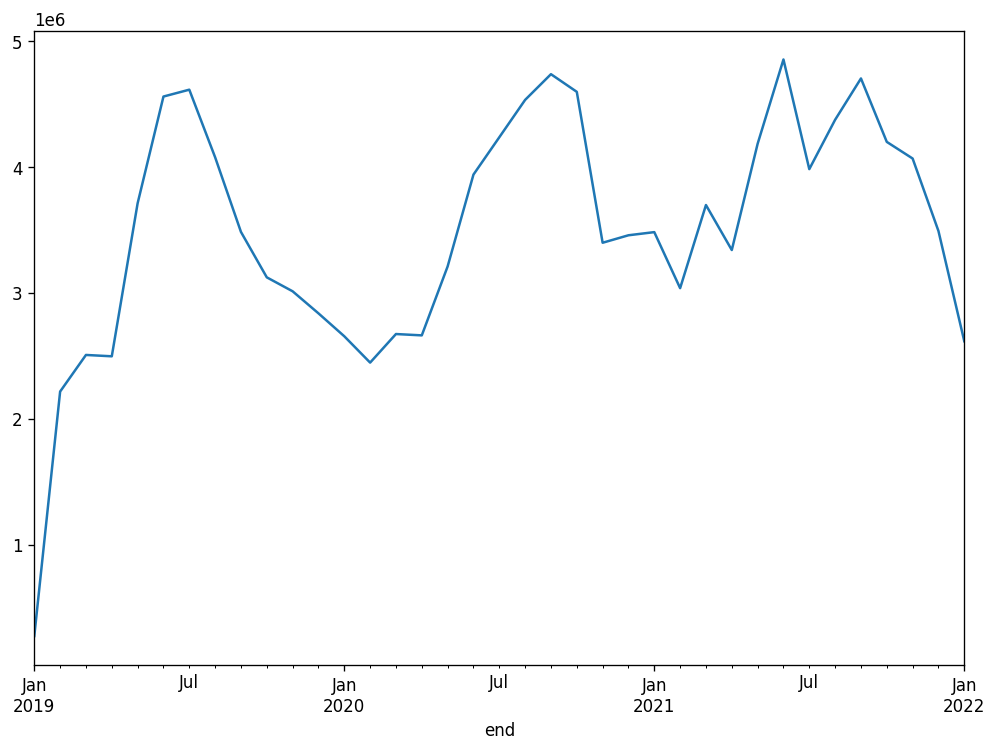

In [368]:
power_data_west_monthly['demand'].plot()

In [369]:
power_data_west_monthly_train = power_data_west_monthly[(power_data_west_monthly['end'] > '2019-01-01') & (power_data_west_monthly['end'] < '2021-01-01')]

In [370]:
power_data_west_monthly_train.drop('end', 1, inplace=True)

/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_85016/2566966477.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  power_data_west_monthly_train.drop('end', 1, inplace=True)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_85016/2566966477.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_data_west_monthly_train.drop('end', 1, inplace=True)


In [371]:
power_data_west_monthly_train

,demand
end,
2019-01-31,277216.00
2019-02-28,2218374.40
2019-03-31,2509120.00
2019-04-30,2498371.21
2019-05-31,3713468.80
2019-06-30,4560950.40
2019-07-31,4615408.00
2019-08-31,4078729.60
2019-09-30,3485974.40


In [372]:
power_data_west_monthly_test = power_data_west_monthly[power_data_west_monthly['end'] > '2021-01-01']

In [373]:
power_data_west_monthly_test.drop('end', 1, inplace=True)

/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_85016/251860318.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  power_data_west_monthly_test.drop('end', 1, inplace=True)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_85016/251860318.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_data_west_monthly_test.drop('end', 1, inplace=True)


In [374]:
power_data_west_monthly_test

,demand
end,
2021-01-31,3484392.00
2021-02-28,3039411.20
2021-03-31,3699497.59
2021-04-30,3342217.60
2021-05-31,4185731.20
2021-06-30,4855107.24
2021-07-31,3984480.00
2021-08-31,4376488.00
2021-09-30,4704580.80


/Users/diveshkumar/Library/Python/3.8/lib/python/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


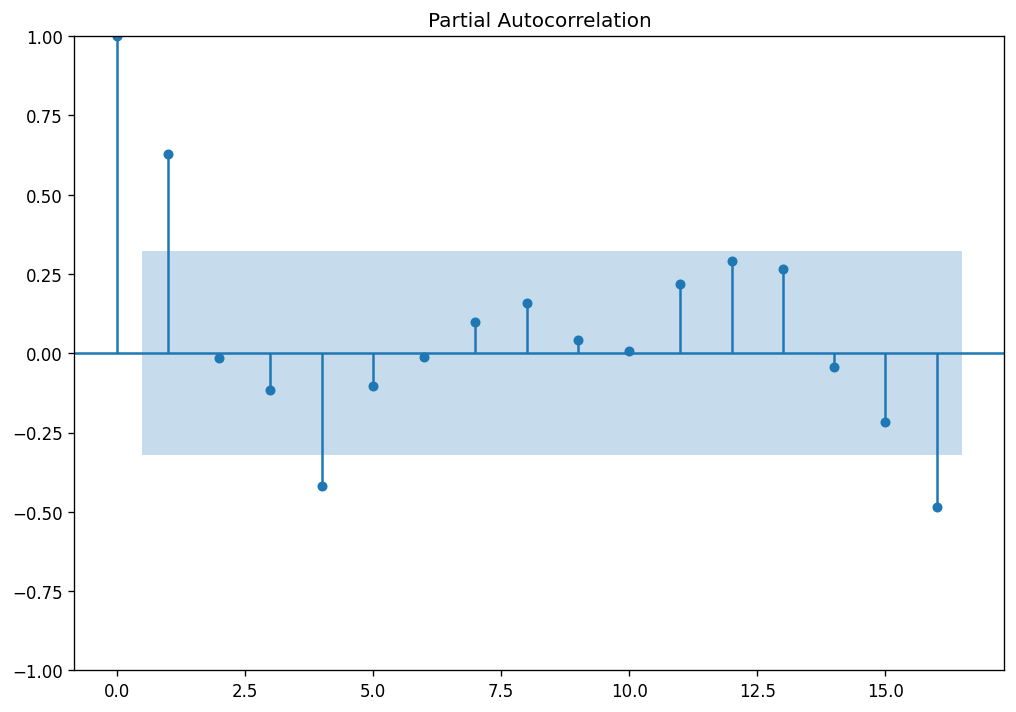

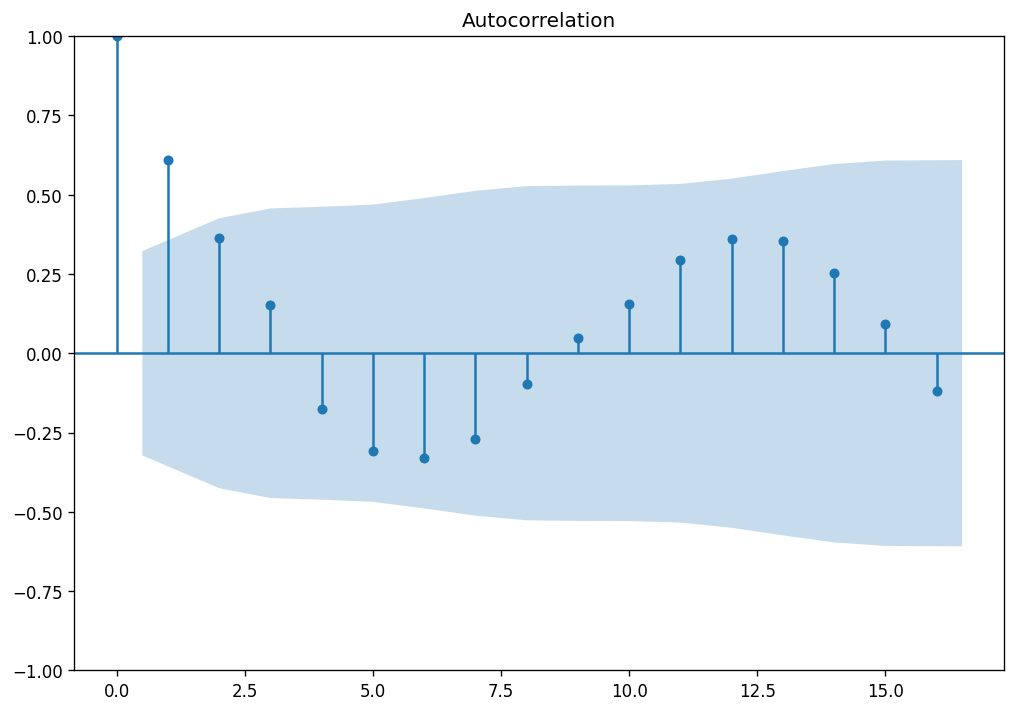

In [375]:
plot_pacf(power_data_west_monthly['demand']);
plot_acf(power_data_west_monthly['demand']);

In [376]:
ad_fuller_result = adfuller(power_data_west_monthly_train['demand'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -6.818120971948836
p-value: 2.0343779504802937e-09


In [291]:
def optimize_SARIMA(parameters_list, d, D, s, exog):
    """
        Return dataframe with parameters, corresponding AIC and SSE
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
        exog - the exogenous variable
    """
    
    results = []
    
    for param in parameters_list:
        try: 
            model = SARIMAX(exog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [159]:
from itertools import product

p = range(0, 3, 1)
d = 1
q = range(0, 3, 1)

P = range(0, 3, 1)
D = 1
Q = range(0, 3, 1)
s = 12

parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))

81


In [160]:
result_df = optimize_SARIMA(parameters_list, 1, 1, 4, power_data_west_monthly_train['demand'])
result_df

/Users/diveshkumar/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/diveshkumar/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/diveshkumar/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/diveshkumar/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWa

/Users/diveshkumar/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/diveshkumar/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/diveshkumar/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/diveshkumar/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWa

,"(p,q)x(P,Q)",AIC
0,"(0, 1, 0, 1)",560.784821
1,"(1, 0, 0, 1)",561.653557
2,"(1, 1, 0, 1)",562.462861
3,"(0, 1, 0, 2)",562.588420
4,"(0, 1, 1, 1)",562.660484
...,...,...
76,"(0, 2, 0, 0)",572.085189
77,"(0, 1, 0, 0)",573.038938
78,"(2, 1, 0, 0)",573.112241
79,"(1, 1, 0, 0)",573.622308


In [377]:
sarima_model = SARIMAX(power_data_west_monthly_train['demand'], order=(0, 1, 1), seasonal_order=(1, 1, 1, 11)).fit(dis=-1)
print(sarima_model.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.59342D+00    |proj g|=  7.88750D-01

At iterate    5    f=  7.27681D+00    |proj g|=  1.73492D-02

At iterate   10    f=  7.27058D+00    |proj g|=  4.95558D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     14      1     0     0   7.078D-06   7.271D+00
  F =   7.2705747177411446     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                                     SARIMAX Results                  

/Users/diveshkumar/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/diveshkumar/Library/Python/3.8/lib/python/site-packages/statsmodels/base/optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: dis. After release 0.14, this will raise.
  warnings.warn(
 This problem is unconstrained.


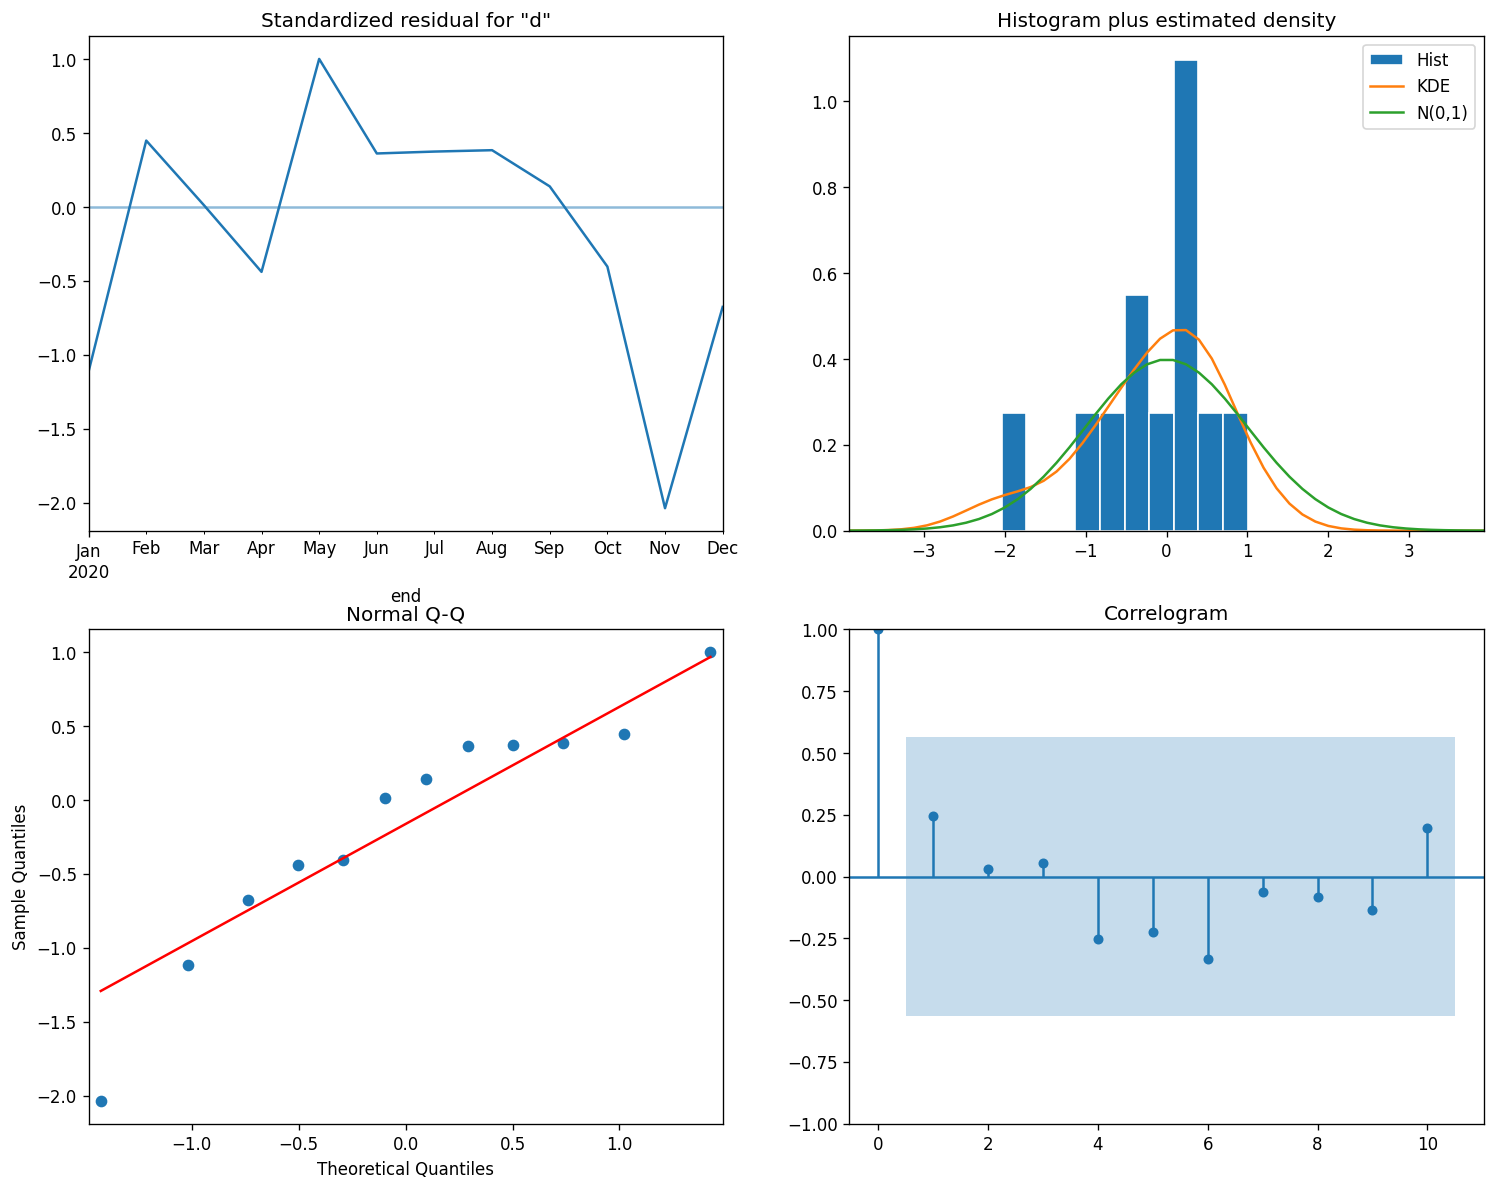

In [378]:
sarima_model.plot_diagnostics(figsize=(15,12));

In [379]:
train = power_data_west_monthly_train['demand'].to_numpy()

In [380]:
fitted = sarima_model.fittedvalues

In [391]:
train_results = pd.DataFrame({'Actual':train, 
                                'Prediction':fitted  })

In [392]:
train_results

,Actual,Prediction
end,,
2019-01-31,277216.00,0.000000e+00
2019-02-28,2218374.40,4.144077e+05
2019-03-31,2509120.00,3.400719e+06
2019-04-30,2498371.21,1.856045e+06
2019-05-31,3713468.80,2.997006e+06
2019-06-30,4560950.40,4.289242e+06
2019-07-31,4615408.00,4.784209e+06
2019-08-31,4078729.60,4.474618e+06
2019-09-30,3485974.40,3.745094e+06


In [393]:
train_results.to_csv('Monthly_SARIMA_Model_Train_Results.csv')

In [381]:
mean_absolute_error_var = mean_absolute_error(train, fitted)
mean_absolute_percentage_error_var = mean_absolute_percentage_error(train, fitted)
mse_error_var = mse_error(train, fitted)
rmse_error_var = rmse_error(train, fitted)

In [382]:
print('Train Set Metrics')
print('MAPE: ' , mean_absolute_percentage_error_var)
print('MAE: ', mean_absolute_error_var)
print('MSE: ', mse_error_var)
print('RMSE: ', rmse_error_var)

Train Set Metrics
MAPE:  18.795401681150008
MAE:  443921.04180003394
MSE:  352888275319.0111
RMSE:  594044.0011640645


In [383]:
forecast = sarima_model.forecast(13)

In [384]:
actual_forecast = pd.DataFrame({'Actual':test, 
                                'Prediction':forecast  })
actual_forecast

,Actual,Prediction
2021-01-31,3484392.00,3.319510e+06
2021-02-28,3039411.20,3.336523e+06
2021-03-31,3699497.59,4.277424e+06
2021-04-30,3342217.60,4.995617e+06
2021-05-31,4185731.20,5.119322e+06
2021-06-30,4855107.24,4.736312e+06
2021-07-31,3984480.00,4.309907e+06
2021-08-31,4376488.00,4.053077e+06
2021-09-30,4704580.80,3.958555e+06
2021-10-31,4200819.20,3.724162e+06


In [385]:
test = power_data_west_monthly_test['demand'].to_numpy()

In [386]:
mean_absolute_error_var = mean_absolute_error(test, forecast)
mean_absolute_percentage_error_var = mean_absolute_percentage_error(test, forecast)
mse_error_var = mse_error(test, forecast)
rmse_error_var = rmse_error(test, forecast)

In [387]:
print('Test Set Metrics')
print('MAPE: ' , mean_absolute_percentage_error_var)
print('MAE: ', mean_absolute_error_var)
print('MSE: ', mse_error_var)
print('RMSE: ', rmse_error_var)

Test Set Metrics
MAPE:  15.775572603144001
MAE:  559319.0920509372
MSE:  511629204253.42847
RMSE:  715282.6044672333


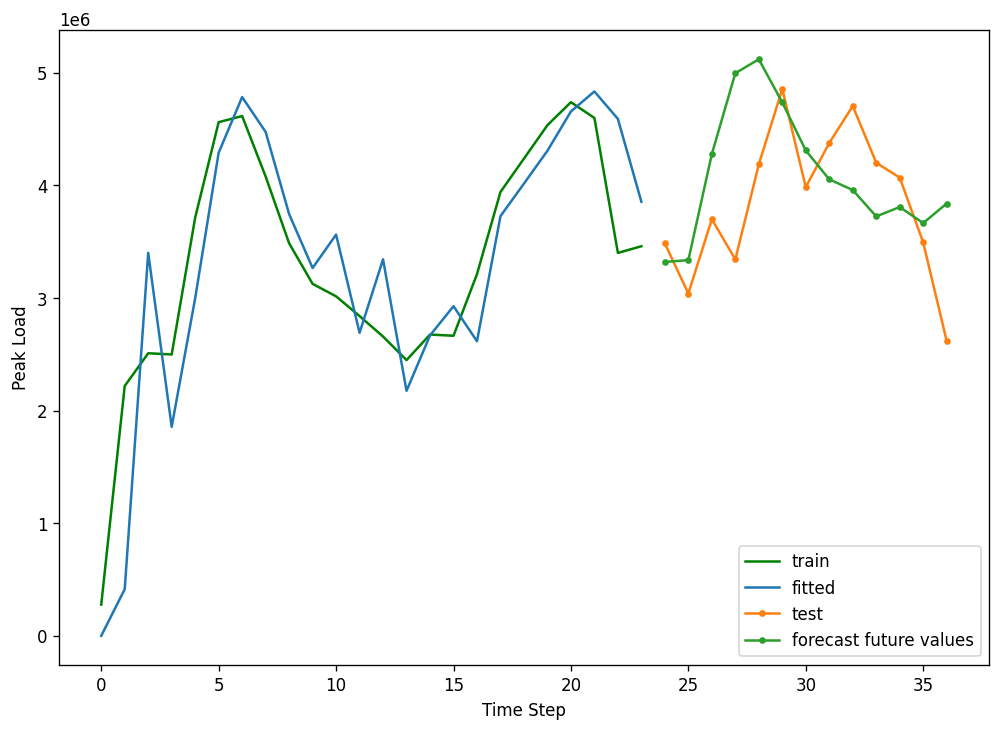

In [388]:
plt.plot(np.arange(0, len(train)), train, 'g', label="train")
plt.plot(np.arange(0, len(train)), fitted, label="fitted")
plt.plot(np.arange(len(train),  len(train) + len(test)), test, marker='.', label="test")
plt.plot(np.arange(len(train),  len(train) + len(test)), forecast, marker='.', label="forecast future values")

plt.ylabel('Peak Load')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [389]:
import joblib
joblib.dump(sarima_model, "./sarima_model_monthly.joblib")

['./sarima_model_monthly.joblib']

In [390]:
actual_forecast.to_csv('Monthly_SARIMA_Model_Test_Results.csv')